In [1]:
import json
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Open and read the JSON file
with open('TP53_mutation_labels.json', 'r') as file:
    data = json.load(file)

rows = []
for key, values in data.items():
    for value in values:
        rows.append({'category': key, 'name': value})

df_mut_label = pd.DataFrame(rows)


In [3]:
import pickle

with open('all_mut_layer_33_pos_mean.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
df = pd.merge(df_mut_label, data, how = "left", on = "name")

In [5]:
with open('all_mut_layer_33_diff.pkl', 'rb') as f:
    data = pickle.load(f)

df = pd.merge(df, data, how = "left", on = "name")

In [6]:
df["Pos"] = df["name"].str[1:-1].astype(int)

In [7]:
## contains some ambiguous amino acids such as B or Z, let's ignore for now
last_chars = set(df[df["embedding_mean"].isna()]["name"].str[-1])

In [8]:
df = df[~df["embedding_mean"].isna()]

In [9]:
df.value_counts("category")

category
Others      5387
DN & LoF     777
Only LoF     540
Only DN      295
Name: count, dtype: int64

In [10]:
# Convert embedding_diff tensors to numpy arrays
embeddings = np.array([t.numpy() for t in df['embedding_diff']])

# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
embeddings_10d = pca.fit_transform(embeddings)

# Add all 10 PCA components to dataframe
for i in range(10):
    df[f'PCA{i+1}'] = embeddings_10d[:, i]

# Display dataframe with new PCA columns
df

,category,name,embedding_mean,embedding_diff,Pos,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
0,DN & LoF,Y103P,"[tensor(-0.0242), tensor(0.1770), tensor(-0.02...","[tensor(-0.0676), tensor(0.0362), tensor(0.176...",103,0.069143,1.165962,-0.690610,1.826103,0.809528,-0.165308,-0.276127,0.188006,0.760848,0.833088
1,DN & LoF,Q104N,"[tensor(-0.0206), tensor(0.1738), tensor(-0.02...","[tensor(0.0798), tensor(-0.0792), tensor(0.229...",104,-0.113559,0.221486,1.004108,0.297343,0.109620,-0.231357,0.450569,0.033292,-0.673333,0.171192
2,DN & LoF,G105F,"[tensor(-0.0274), tensor(0.1697), tensor(-0.02...","[tensor(-0.0643), tensor(-0.0181), tensor(0.17...",105,0.032326,-0.749890,0.047568,0.178081,0.476534,-1.040533,-2.003310,0.803712,-0.720265,-0.602848
3,DN & LoF,G105I,"[tensor(-0.0271), tensor(0.1704), tensor(-0.02...","[tensor(-0.1742), tensor(-0.0325), tensor(0.12...",105,0.055058,-0.812101,0.283085,0.840533,0.640127,-0.341670,-1.923915,0.779035,0.199062,-0.768572
4,DN & LoF,G105L,"[tensor(-0.0272), tensor(0.1707), tensor(-0.02...","[tensor(-0.0803), tensor(-0.0314), tensor(0.12...",105,0.190503,-2.006174,0.001797,1.084566,1.261206,0.054511,-2.124361,0.999679,0.397388,-0.019866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7781,Others,D393S,"[tensor(-0.0249), tensor(0.1759), tensor(-0.02...","[tensor(-0.2499), tensor(-0.0110), tensor(0.03...",393,-2.003021,0.512613,1.371473,1.246332,0.492057,0.900641,-0.588924,-2.013100,0.246837,-0.070779
7782,Others,D393T,"[tensor(-0.0231), tensor(0.1754), tensor(-0.02...","[tensor(-0.0735), tensor(0.0936), tensor(-0.06...",393,-1.901546,0.924329,0.019280,-0.590382,2.575469,0.382190,-0.219173,-1.588913,1.354660,-0.143546
7783,Others,D393V,"[tensor(-0.0222), tensor(0.1749), tensor(-0.02...","[tensor(-0.0046), tensor(0.0367), tensor(-0.11...",393,-1.649645,-0.080502,-0.262652,0.507300,0.215695,0.724597,-0.410731,-1.952810,1.244700,-1.897036
7784,Others,D393W,"[tensor(-0.0224), tensor(0.1722), tensor(-0.02...","[tensor(-0.0679), tensor(-0.1721), tensor(-0.0...",393,-1.322550,-0.380049,-0.209847,0.728019,0.506844,0.484901,-0.492269,-1.519992,0.969957,-0.732583


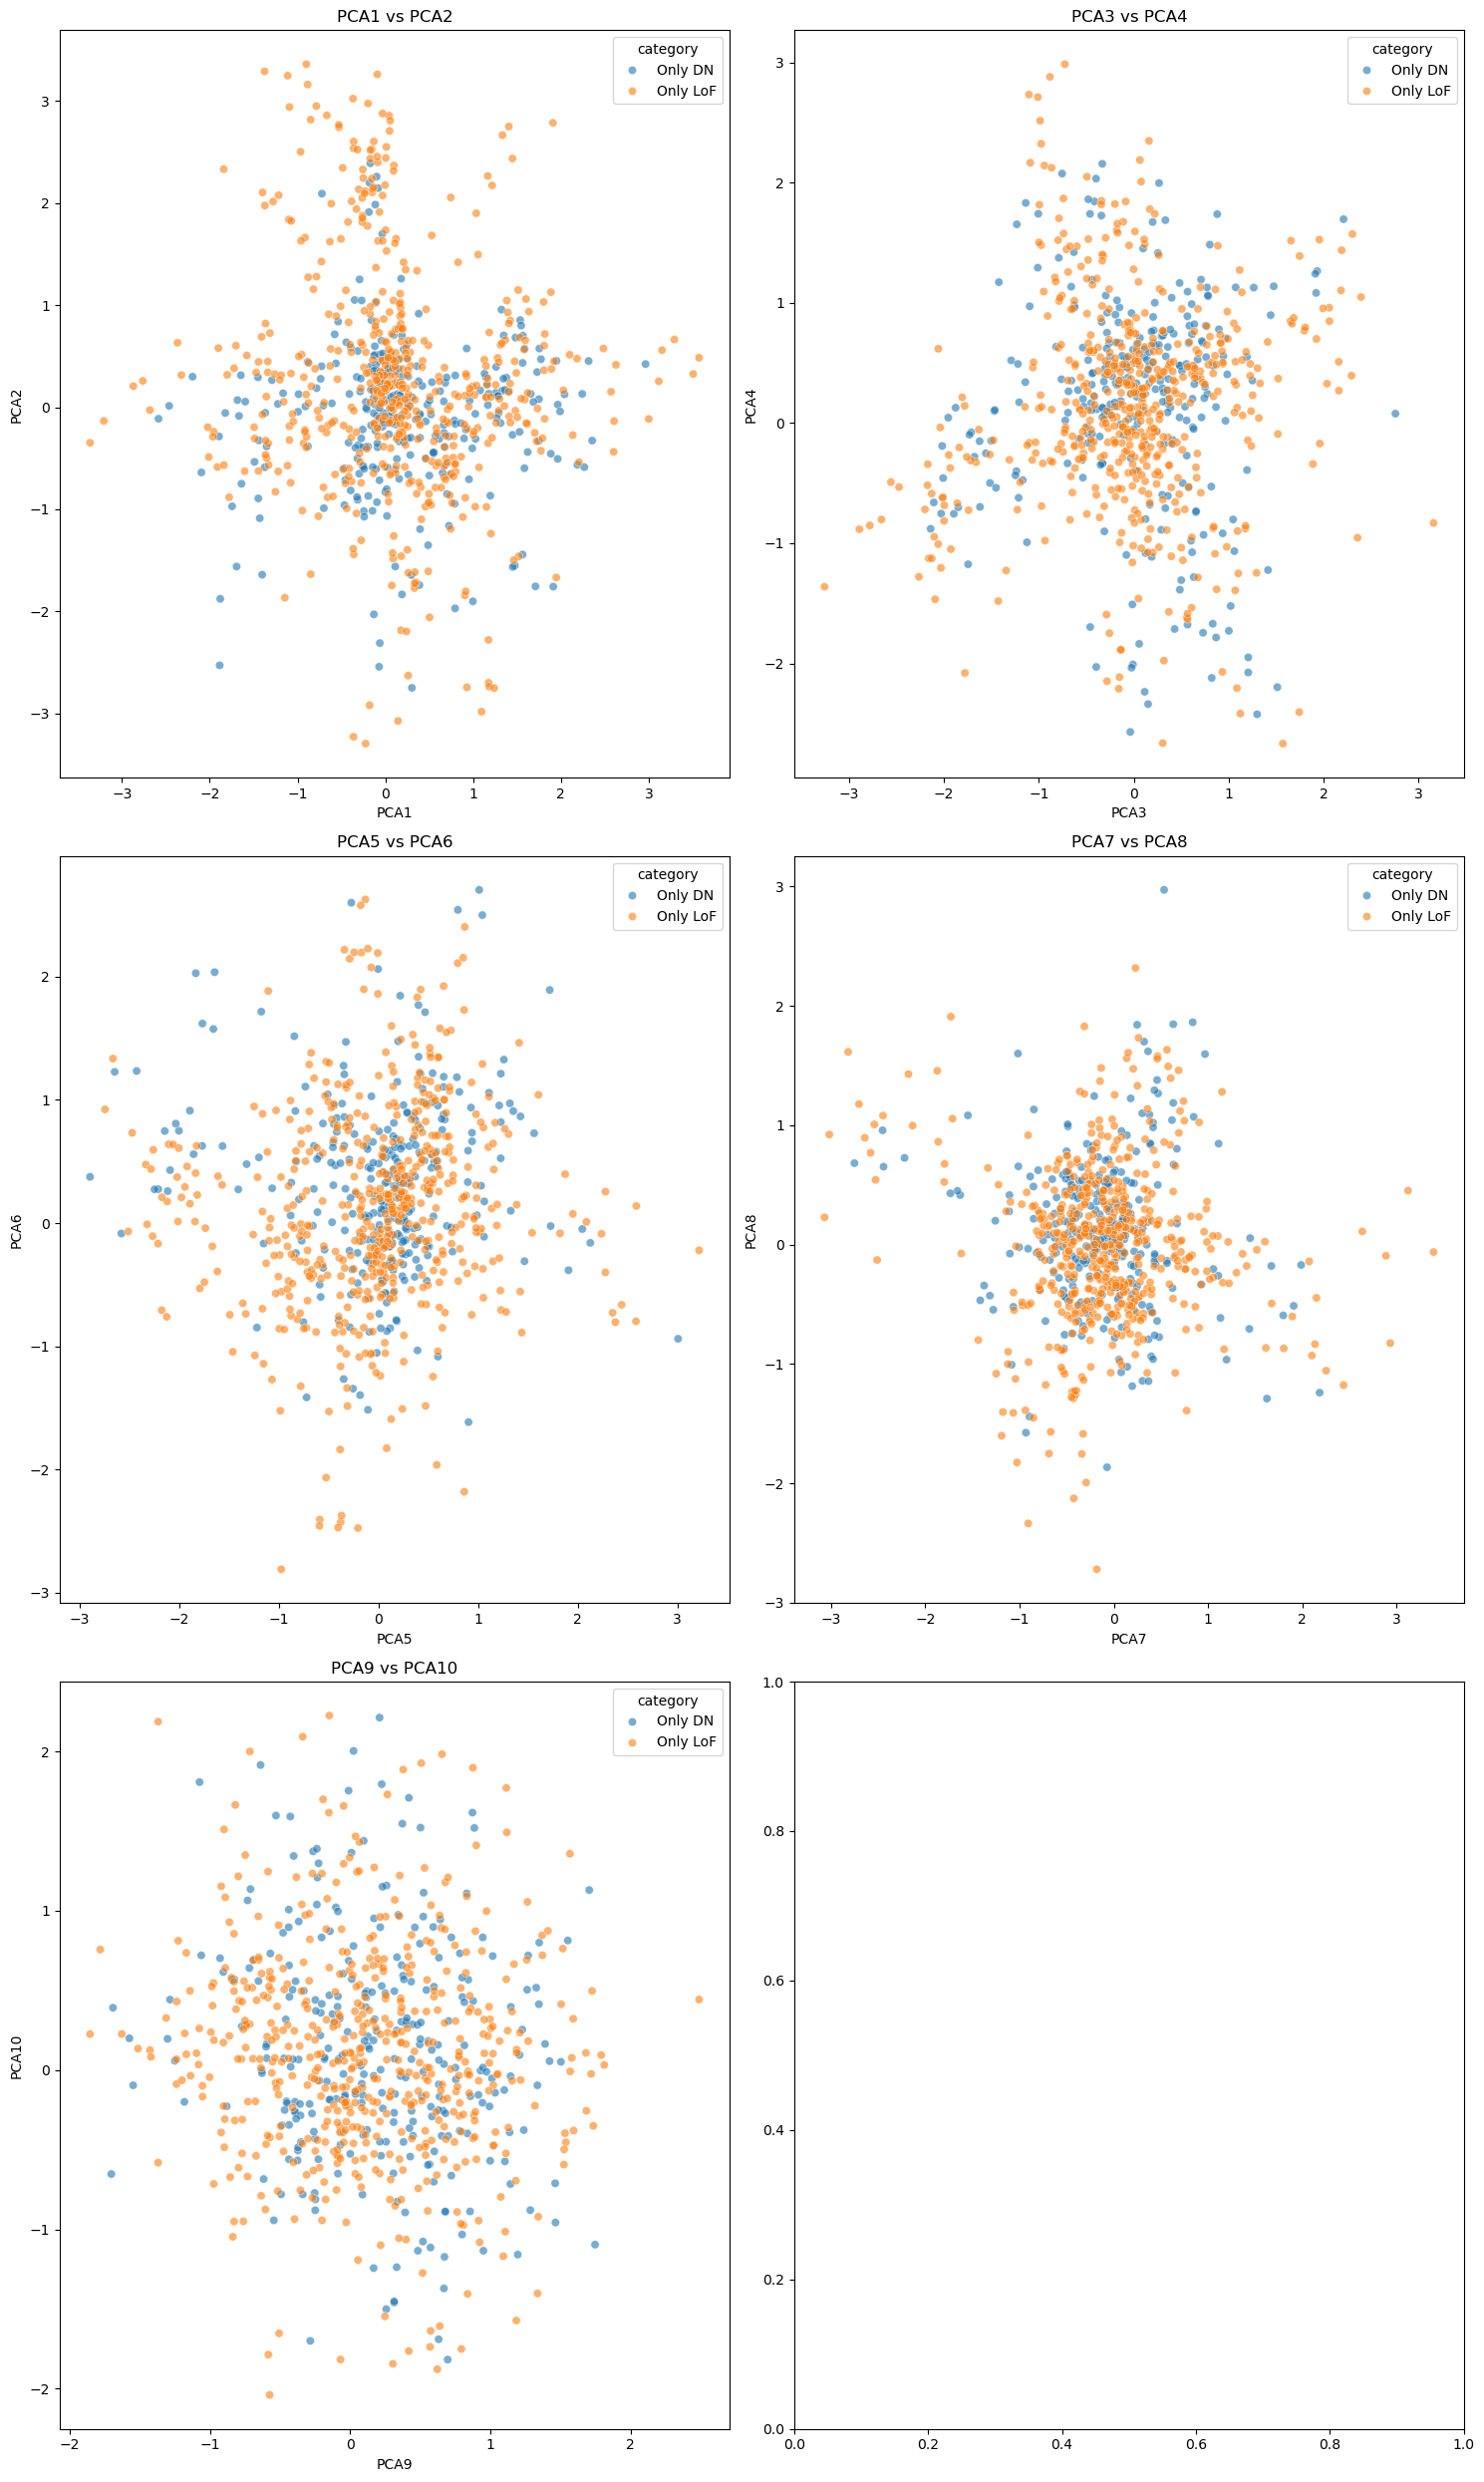

In [11]:
import seaborn as sns

# Create a figure with 5 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 25))
axes = axes.flatten()

# Plot each pair of consecutive PCAs
for i in range(0, 10, 2):
    # First PCA vs next PCA
    sns.scatterplot(data=df[df['category'].isin(['Only DN', 'Only LoF'])],
                    x=f'PCA{i+1}', y=f'PCA{i+2}', 
                    hue='category', alpha=0.6,
                    ax=axes[i//2])
    axes[i//2].set_title(f'PCA{i+1} vs PCA{i+2}')

plt.tight_layout()


In [12]:
# Load the difference vector
difference_vector = torch.load('difference_vector_unit.pt')


/var/folders/wx/z2j6vh_s593cjs7xx71k0q780000gq/T/ipykernel_44968/2794477833.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  difference_vector = torch.load('difference_ve

In [13]:
# Convert difference_vector to numpy array
diff_vec_np = difference_vector.numpy()

# Calculate cosine similarity between difference vector and each PCA component
similarities = []
for i in range(10):
    pca_component = pca.components_[i]
    similarity = np.dot(diff_vec_np, pca_component) / (np.linalg.norm(diff_vec_np) * np.linalg.norm(pca_component))
    similarities.append(similarity)

# Create dataframe of results
similarity_df = pd.DataFrame({
    'PCA Component': [f'PCA{i+1}' for i in range(10)],
    'Cosine Similarity': similarities
})

# Sort by absolute similarity
similarity_df['Abs Similarity'] = abs(similarity_df['Cosine Similarity'])
similarity_df = similarity_df.sort_values('Abs Similarity', ascending=False)

print("Cosine similarities between difference vector and PCA components:")
print(similarity_df)


Cosine similarities between difference vector and PCA components:
  PCA Component  Cosine Similarity  Abs Similarity
1          PCA2           0.496436        0.496436
5          PCA6          -0.298441        0.298441
7          PCA8          -0.244866        0.244866
2          PCA3          -0.143973        0.143973
8          PCA9          -0.136039        0.136039
4          PCA5          -0.074742        0.074742
3          PCA4          -0.070226        0.070226
6          PCA7           0.067619        0.067619
0          PCA1          -0.059456        0.059456
9         PCA10           0.011459        0.011459


/Users/daniellee/miniforge3/envs/py312/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


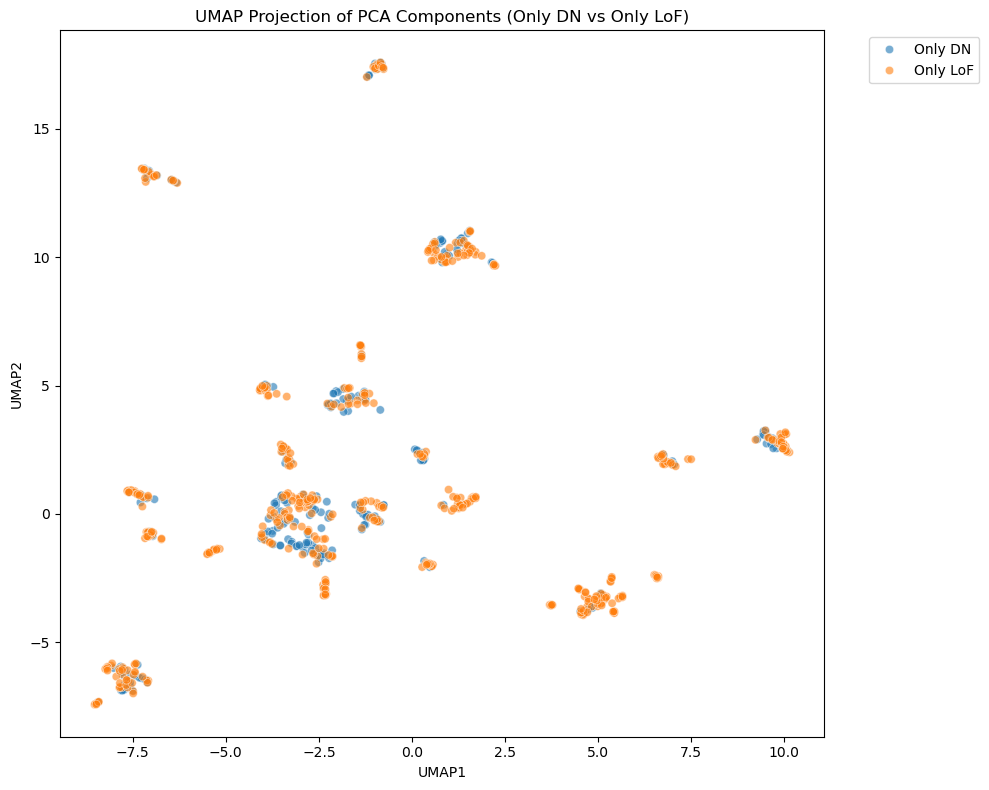

In [22]:
# Perform UMAP on the PCA data
import umap
# Filter for Only DN and Only LoF categories
df_filtered = df[df['category'].isin(['Only DN', 'Only LoF'])]

umap_reducer = umap.UMAP(random_state=42)
umap_embeddings = umap_reducer.fit_transform(df_filtered[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10']].values)

# Create scatter plot of UMAP embeddings
plt.figure(figsize=(10,8))
sns.scatterplot(x=umap_embeddings[:,0], y=umap_embeddings[:,1], 
                hue=df_filtered['category'], alpha=0.6)
plt.title('UMAP Projection of PCA Components (Only DN vs Only LoF)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
